# Feature Importance Analysis (Program Characteristics Only)

This notebook analyzes distinguishing features between upskilling and reskilling programs, focusing exclusively on program characteristics and excluding outcome variables. The analysis includes:
- Data preparation with explicit outcome variable exclusion
- Feature selection focused on program characteristics
- XGBoost modeling with cross-validation
- SHAP analysis for feature interpretation

## 1. Data Preparation and Feature Selection
- Import required libraries
- Load and prepare data
- Select program characteristics
- Remove outcome variables
- Create target variable
- Split data for training and validation

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score
import shap
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')

# Set visualization parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Load data
data = pd.read_stata("../Data/V1_qualflags_analysis2_ML.dta")
df, meta = pyreadstat.read_dta("../Data/V1_qualflags_analysis2_ML.dta")
variable_labels = dict(zip(data.columns, meta.column_labels))

# Create dummy variables
data_dummies = pd.get_dummies(data)

# Clean column names
new_cols = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_') 
            for col in data_dummies.columns]
data_dummies.columns = new_cols
data_dummies = data_dummies.replace({True: 1, False: 0})

# Create target variable
outcomes = [1 if out == 'Reskilling' else 0 for out in data['program']]

# Select program-specific variables
program_variables = [
    'p_participated_2023', 'p_mandavolunt', 'p_year_start', 'p_year_end', 'p_ongoing', 
    'p_program_length', 'p_hourstrained', 'p_duration', 'p_comphours', 'p_otjactivities', 
    'p_cost', 'p_adequatefund', 'p_adequatefunddummy', 'p_fund_gov', 'p_fund_org', 
    'p_fund_wrk', 'p_fund_union', 'p_fund_other', 'p_advocacy', 'p_advocacy_hier', 
    'p_responsibility', 'p_responsibility_hier', 'p_application', 'p_selection', 
    'p_criteria_jobtitle', 'p_criteria_tenure', 'p_criteria_qualifications', 
    'p_criteria_assmskills', 'p_criteria_assmsmotivation', 'p_criteria_managerrec', 
    'p_criteria_other', 'p_targetemp_c', 'p_targetemp_bul', 'p_targetemp_mm', 
    'p_targetemp_emp', 'p_targetfunc_leg', 'p_targetfunc_hr', 'p_targetfunc_adm', 
    'p_targetfunc_it', 'p_targetfunc_op', 'p_targetfunc_mrksal', 'p_targetfunc_rd', 
    'p_targetfunc_accfin', 'p_targetfunc_cust', 'p_difloc', 'p_difstand', 'p_eligibility', 
    'p_part', 'p_part_exp', 'dd_pilot_length', 'dd_pilot_dummy', 'dd_pilot_ct', 
    'dd_pilot_over', 'dd_design_board', 'dd_design_c', 'dd_design_hr', 'dd_design_bul', 
    'dd_design_mm', 'dd_design_emp', 'dd_design_union', 'dd_design_ia', 'dd_external', 
    'dd_extdesign_ta', 'dd_extdesign_gov', 'dd_extdesign_acad', 'dd_extdesign_lsshelf', 
    'dd_extdesign_custom', 'dd_extdesign_all', 'dd_delivery', 'mot_mgragg', 'mot_wrkagg', 
    'inc_mgr_fin', 'inc_mgr_nofin', 'inc_mgr_rec', 'inc_mgr_intrin', 'inc_mgr_none', 
    'inc_mgr_all', 'inc_wrk_career', 'inc_wrk_risk', 'inc_wrk_fin', 'inc_wrk_nofin', 
    'inc_wrk_cert', 'inc_wrk_rec', 'inc_wrk_strat', 'inc_wrk_job', 'inc_wrk_all', 
    'exp_participation', 'p_finassessment', 'k_track_numberppl', 'k_track_hours', 
    'k_track_attract', 'k_track_completion', 'k_track_changeskill', 'k_track_changecareer', 
    'k_track_otherHR', 'k_track_busoutcomes', 'k_track_benefitstraining', 'k_track_other', 
    'k_track_none', 'k_review_BoD', 'k_review_c', 'k_review_hr', 'k_review_bul', 
    'k_review_mm', 'k_review_emp', 'k_review_union', 'k_review_ia', 'k_review_other', 
    'k_reviewcombined_c', 'k_reviewcombined_hr', 'k_reviewcombined_others', 'k_freq', 
    'mot_mgragg', 'mot_wrkagg', 'inc_mgr_fin', 'inc_mgr_nofin', 'inc_mgr_rec', 
    'inc_mgr_intrin', 'inc_mgr_none', 'inc_mgr_all', 'inc_wrk_career', 'inc_wrk_risk', 
    'inc_wrk_fin', 'inc_wrk_nofin', 'inc_wrk_cert', 'inc_wrk_rec', 'inc_wrk_strat', 
    'inc_wrk_job', 'inc_wrk_all', 'exp_participation', 'p_finassessment', 
    'k_track_numberppl', 'k_track_hours', 'k_track_attract', 'k_track_completion', 
    'k_track_changeskill', 'k_track_changecareer', 'k_track_otherHR', 'k_track_busoutcomes', 
    'k_track_benefitstraining', 'k_track_other', 'k_track_none', 'k_review_BoD', 
    'k_review_c', 'k_review_hr', 'k_review_bul', 'k_review_mm', 'k_review_emp', 
    'k_review_union', 'k_review_ia', 'k_review_other', 'k_reviewcombined_c', 
    'k_reviewcombined_hr', 'k_reviewcombined_others', 'k_freq'
]

# Define outcome variables to exclude
outcomes_to_exclude = [
    'p_cont_investment',
    'p_challenge_convincingemployees',
    'p_challenge_selecting',
    'p_challenge_progcompl',
    'p_challenge_learning',
    'p_challenge_newjob',
    'p_challenge_convmanager',
    'p_challenge_linkprogramcareer',
    'p_challenge_effectiveness',
    'p_challenge_scaling',
    'p_challenge_determreturn',
    'p_challenge_supportoutsideHR',
    'p_challenge_funding',
    'p_challenge_other',
    'p_effectiveness',
    'k_track_hours'
]

# Filter dataset to include only program variables
program_data = data_dummies[data_dummies.columns.intersection(program_variables)]
program_data = program_data.drop(columns=outcomes_to_exclude, errors='ignore')

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    program_data, outcomes, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Feature Importance Analysis with XGBoost
- Iterative feature selection on program characteristics
- Model training excluding outcomes
- Performance evaluation with ROC and additional metrics
- Feature importance ranking for program-specific variables

Removing highest importance feature: p_program_length
AUC score at loop 0: 0.779
Top feature importances at loop 0:
  p_program_length: 0.039
  inc_mgr_none: 0.036
  inc_wrk_job: 0.036
Updated best AUC score to: 0.779 with 64 features

Training final model...

Top 10 most important features:
dd_design_board: 0.113
k_review_emp: 0.032
inc_wrk_job: 0.031
p_fund_union: 0.030
dd_design_hr: 0.029
dd_design_mm: 0.026
dd_design_bul: 0.026
p_criteria_jobtitle: 0.025
inc_mgr_none: 0.023
p_fund_other: 0.023

Additional Performance Metrics:
Precision: 0.736
Recall: 0.690
F1 Score: 0.712


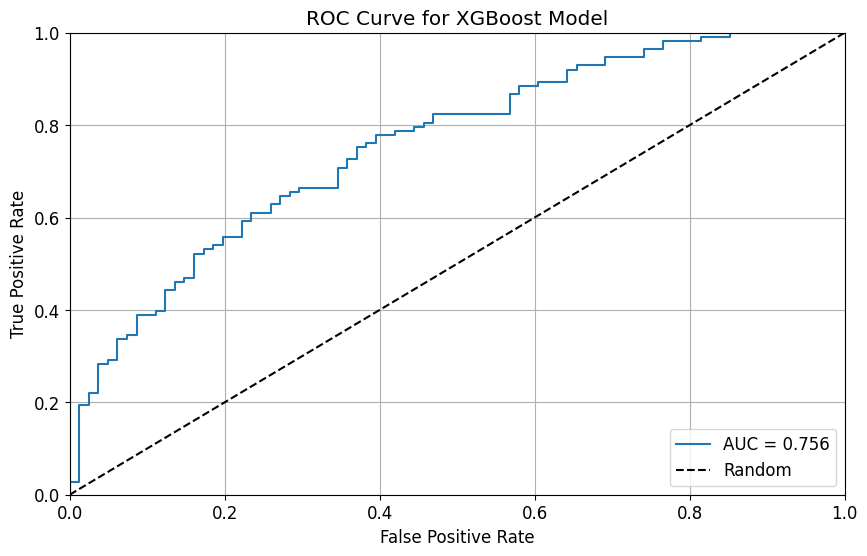

In [2]:

# Feature importance analysis functions
def model_loop(X, y):
    """
    Train a new model with inputs X, y
    Return feature importances and the model object
    """
    xgb_mod_loop = xgb.XGBClassifier(random_state=42)
    xgb_mod_loop.fit(X, y)
    feature_imps = list(zip(X.columns, xgb_mod_loop.feature_importances_))
    return feature_imps, xgb_mod_loop

def get_remove_features(feature_imps):
    """
    Removes all features with importance of 1 or the highest importance feature
    """
    one_list = [i[0] for i in feature_imps if i[1] == 1]
    if one_list:
        print(f"Removing features with importance 1: {one_list}")
        return one_list
    else:
        feat_to_remove = sorted(feature_imps, key=lambda x: x[1], reverse=True)[0][0]
        print(f"Removing highest importance feature: {feat_to_remove}")
        return [feat_to_remove]

def remove_features(X, feat_list):
    """Remove specified features from dataset"""
    new_cols = [i for i in X.columns if i not in feat_list]
    return X[new_cols]

# Iterative feature selection
auc_score = 1
loop_num = 0
AUC_lim = 1  # Set minimum AUC threshold
best_auc = 0

auc_list = []
num_features = []

while auc_score >= AUC_lim:
    # Train model and get feature importances
    feature_imps, mod = model_loop(X_train, y_train)

    # Identify features to remove
    feats_to_remove = get_remove_features(feature_imps)
    
    # Calculate AUC score
    y_pred_proba = mod.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    
    # Track metrics
    auc_list.append(auc_score)
    num_features.append(len(X_train.columns))
    
    # Remove features and update datasets
    X_train = remove_features(X_train, feats_to_remove)
    X_val = remove_features(X_val, feats_to_remove)
    
    # Print iteration results
    print(f"AUC score at loop {loop_num}: {auc_score:.3f}")
    print(f"Top feature importances at loop {loop_num}:")
    top_3 = sorted(feature_imps, key=lambda x: x[1], reverse=True)[:3]
    for feat, imp in top_3:
        print(f"  {feat}: {imp:.3f}")
    
    # Track best performance
    if auc_score >= best_auc:
        best_auc = auc_score
        print(f"Updated best AUC score to: {best_auc:.3f} with {len(X_train.columns)} features")
    
    loop_num += 1
    
    # Check if all columns have been removed
    if len(X_train.columns) == 0:
        print("All columns removed")
        break

# Train final XGBoost model
print("\nTraining final model...")
xgb_mod = xgb.XGBClassifier(random_state=42)
xgb_mod.fit(X_train, y_train)

# Get final feature importances
main_model_feats = list(zip(X_train.columns, xgb_mod.feature_importances_))
most_imp = sorted(main_model_feats, key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most important features:")
for feat, imp in most_imp:
    print(f"{feat}: {imp:.3f}")

# Plot ROC curve and get AUC score
y_pred_proba = xgb_mod.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc_score = roc_auc_score(y_val, y_pred_proba)

# Calculate additional metrics
y_pred = xgb_mod.predict(X_val)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("\nAdditional Performance Metrics:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Create ROC plot
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 3. SHAP Value Analysis
- SHAP analysis on program characteristics
- Visualization of feature contributions
- Top feature interpretation excluding outcomes

PermutationExplainer explainer: 195it [01:01,  3.17it/s]                         


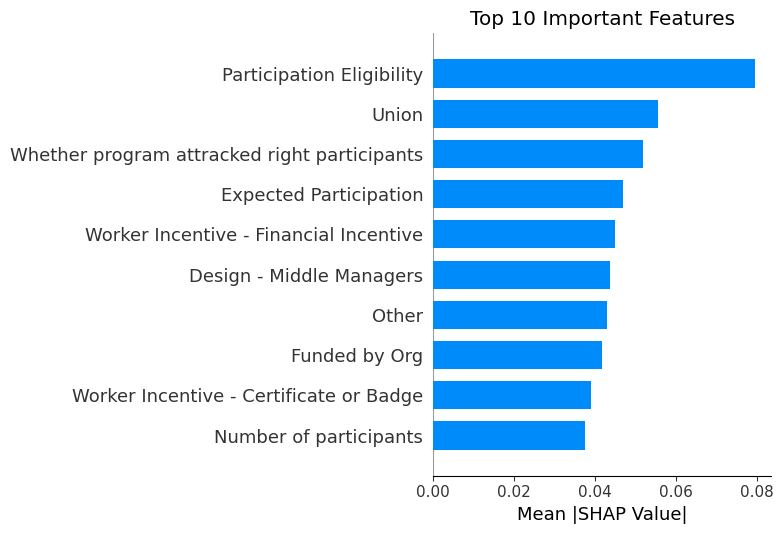

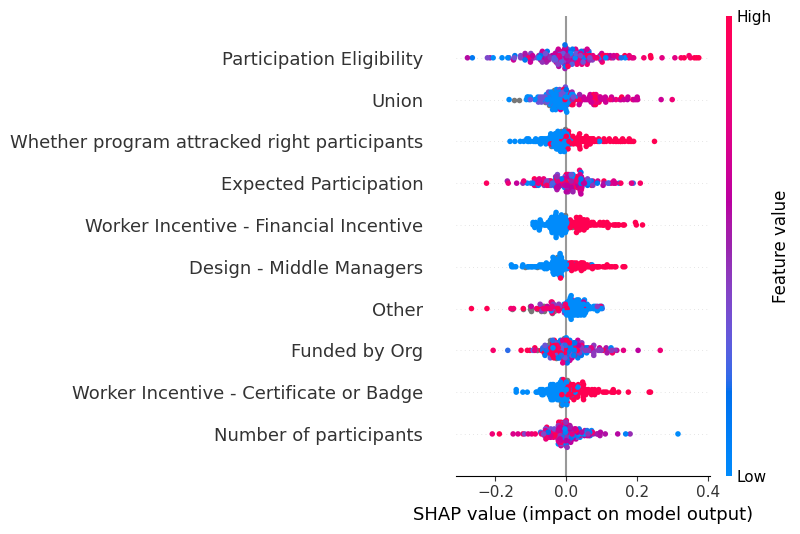

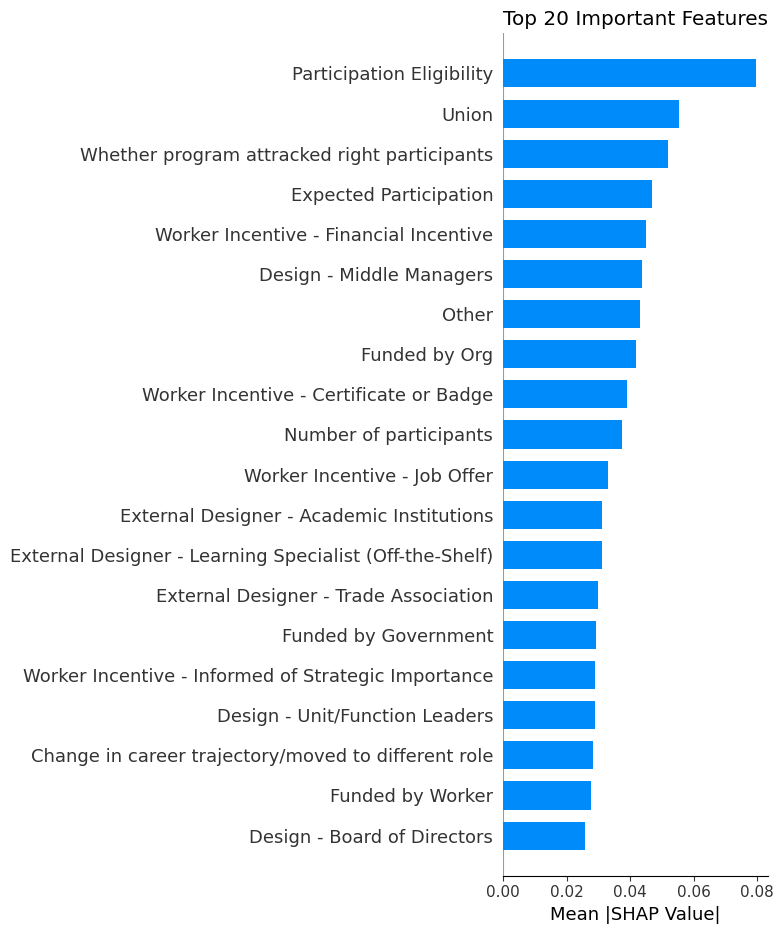

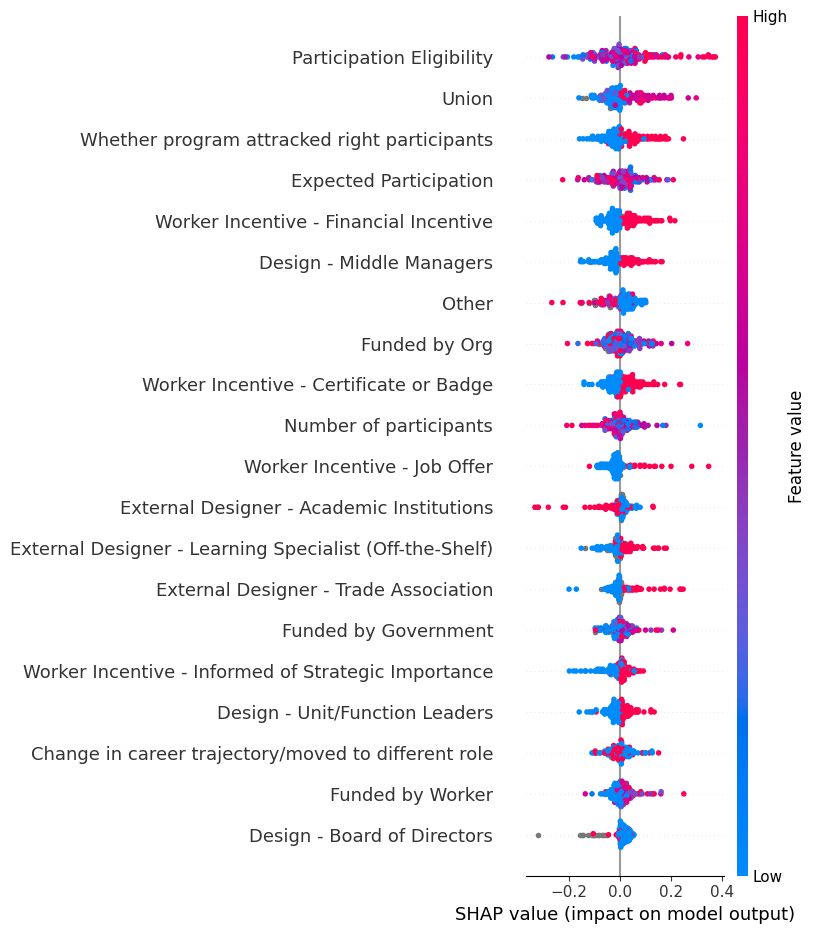

In [3]:
# Prepare feature labels
label_mapping = {
    'roi4': 'Negative ROI',
    'roi_yes': 'ROI Measured',
    'ecp_extredeployment': 'External Redeployment',
    'p_effect_reverse': 'Program Effectiveness',
    'evp_network': 'Cross-departmental Networks',
    'roi5': 'Positive ROI',
    'sum_tr_sk': 'Sum of Trained Skills',
    'sha_b_sk_n_digital': 'Share Needed Digital Skills',
    'stat_government': 'Help Org Use Gov Subsidy',
    'ecp_intredeployment': 'Internal Redeployment',
    'stat_csr': 'Fulfilling CSR Requirement',
    'reason_dei': 'Reason DEI',
    'sk_selected': 'Total Nr skills needed',
    'stand2': 'Mix Standardization customization',
    'f_union_1 - 25%': 'Union Share 1-25%',
    'inc_mgr_nofin': 'Manager: Non-financial Incentive',
    'invest_cont': 'Continued Investment',
    'p_fund_gov': 'Funded by Government',
    'f_medium': 'Medium Firm Size (100-999)',
    'roi2': 'Not yet but intend to calculate ROI',
    'roi3': 'Tried to but unable to',
    'roi1': 'No attempt to calculate',
    'p_eligibility': 'Participation Eligibility',
    'p_targetfunc_it_Not Selected': 'Target Function: IT not selected',
    'p_cont_investment_Very likely': 'Cont. Investment Very Likely',
    'p_adv_hr': 'Advocate HR',
    'p_participated_2023_1000 - 9999': 'Participated in 2023 (1000 - 9999)',
    'p_program_length': 'Program Length (Years)',
    'p_fund_org': 'Funded by Org',
    'p_criteria_jobtitle': 'Selection Criteria: Job Title',
    'p_criteria_assmskills': 'Selection Criteria: Assessment of Skills',
    'p_target_emp': 'Target Group: Employees',
    'p_challenge_progcompl': 'Challenge: Program Completion',
    'p_year_end_2023': 'Program End: 2023',
    'p_part': 'Number of participants',
    'p_fund_wrk': 'Funded by Worker',
    'sha_b_sk_n_soft': 'Needed share soft skill',
    'sha_b_sk_n_man': 'Needed share mgmt skill',
    'p_part_exp': 'Expected Participation',
    'tot_kpi_tracked': 'Total Nr of KPIs'
}

# Add any missing labels from variable_labels
for key, value in variable_labels.items():
    if key not in label_mapping:
        label_mapping[key] = value if value else key

# Map feature names to labels
mapped_features = [label_mapping.get(feature, feature) for feature in X_train.columns]
mapped_features = [f for f in mapped_features if f is not None]

# Calculate SHAP values
explainer = shap.Explainer(xgb_mod.predict, X_train)
shap_values = explainer.shap_values(X_val)

# Calculate feature importance based on SHAP values
importances = np.abs(shap_values).mean(0)

# Top 10 Features Analysis
top_10_indices = np.argsort(importances)[-10:]
top_10_indices = top_10_indices[np.argsort(importances[top_10_indices])]
top_10_features = [mapped_features[i] for i in top_10_indices]

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values[:, top_10_indices],
    feature_names=top_10_features,
    plot_type="bar",
    show=False
)
plt.title("Top 10 Important Features")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()

# Detailed SHAP plot for top 10
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values[:, top_10_indices],
    X_val.iloc[:, top_10_indices],
    feature_names=top_10_features
)

# Top 20 Features Analysis
top_20_indices = np.argsort(importances)[-20:]
top_20_indices = top_20_indices[np.argsort(importances[top_20_indices])]
top_20_features = [mapped_features[i] for i in top_20_indices]

plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values[:, top_20_indices],
    feature_names=top_20_features,
    plot_type="bar",
    show=False
)
plt.title("Top 20 Important Features")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()

# Detailed SHAP plot for top 20
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values[:, top_20_indices],
    X_val.iloc[:, top_20_indices],
    feature_names=top_20_features
)